# Scalable GP Regression in 1D (w/ KISS-GP)

## Introduction

For 1D functions, SKI (or KISS-GP) is a great way to scale a GP up to very large datasets (100,000+ data points).
Kernel interpolation for scalable structured Gaussian processes (KISS-GP) was introduced in this paper:
http://proceedings.mlr.press/v37/wilson15.pdf

SKI is asymptotically very fast (nearly linear), very precise (error decays cubically), and easy to use in GPyTorch!
As you will see in this tutorial, it's really easy to apply SKI to an existing model. All you have to do is wrap your kernel module with a `GridInterpolationKernel`.

In [161]:
import math 
import torch
import os
import gpytorch
from matplotlib import pyplot as plt

# Make plots inline
# %matplotlib inline

### Set up training data

We'll learn a simple sinusoid, but with lots of training data points. At 1000 points, this is where scalable methods start to become useful.

In [164]:
X_tensor = torch.randn(1000) * 5
X_tensor_arr = X_tensor.detach().numpy()
X_tensor_arr.sort()
X_tensor = torch.tensor(X_tensor_arr)
train_x = X_tensor
train_y = torch.sin(train_x * (4 * math.pi) + torch.randn(train_x.size()) * 0.2)

## Set up the model

The model should be somewhat similar to the `ExactGP` model in the [simple regression example](../01_Simple_GP_Regression/Simple_GP_Regression.ipynb).

The only difference: we're wrapping our kernel module in a `GridInterpolationKernel`. This signals to GPyTorch that you want to approximate this kernel matrix with SKI.

SKI has only one hyperparameter that you need to worry about: the grid size. For 1D functions, a good starting place is to use as many grid points as training points. (Don't worry - the grid points are really cheap to use!). You can use the `gpytorch.utils.grid.choose_grid_size` helper to get a good starting point.

If you want, you can also explicitly determine the grid bounds of the SKI approximation using the `grid_bounds` argument. However, it's easier if you don't use this argument - then GPyTorch automatically chooses the best bounds for you.

In [165]:
class KISS_GP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, grid_size=30):
        super(KISS_GP, self).__init__(train_x, train_y, likelihood)
        
        # SKI requires a grid size hyperparameter. This util can help with that. Here we are using a grid that has the same number of points as the training data (a ratio of 1.0). Performance can be sensitive to this parameter, so you may want to adjust it for your own problem on a validation set.
#         grid_size = gpytorch.utils.grid.choose_grid_size(train_x,1.0)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.GridInterpolationKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
            grid_size=grid_size, num_dims=1,
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
likelihood = gpytorch.likelihoods.GaussianLikelihood()
kiss_40_model = KISS_GP(train_x, train_y, likelihood, 40)
kiss_150_model = KISS_GP(train_x, train_y, likelihood, 150)
exact_GP_model = ExactGPModel(train_x, train_y, likelihood)

In [215]:
import numpy as np
from matplotlib import pyplot as plt
X_tensor = torch.randn(1000)
X_tensor_arr = X_tensor.detach().numpy()
X_tensor_arr.sort()
X_tensor = torch.tensor(X_tensor_arr)

kiss_40_model_cov = kiss_40_model.covar_module(X_tensor).evaluate().detach().numpy()
kiss_150_model_cov = kiss_150_model.covar_module(X_tensor).evaluate().detach().numpy()
exact_GP_cov = exact_GP_model.covar_module(X_tensor).evaluate().detach().numpy()

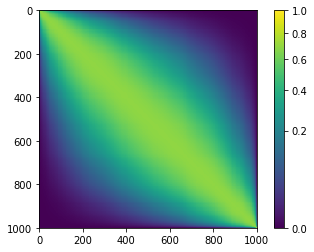

In [220]:
fig, ax = plt.subplots()
from matplotlib import colors
im = ax.imshow(exact_GP_cov, interpolation='nearest',vmin=0, vmax=1,norm=colors.PowerNorm(gamma=1. / 2.),)
fig.colorbar(im)
plt.show()

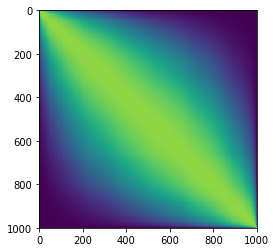

In [219]:
plt.imshow(kiss_40_model_cov, interpolation='nearest',vmin=0, vmax=1,norm=colors.PowerNorm(gamma=1. / 2.),)
plt.show()

# Make predictions

SKI is especially well-suited for predictions. It can comnpute predictive means in constant time, and with LOVE enabled (see [this notebook](../05_Scalable_GP_Regression_Multidimensional/KISSGP_Deep_Kernel_Regression_With_LOVE_Fast_Variances_CUDA.ipynb)), predictive variances are also constant time.

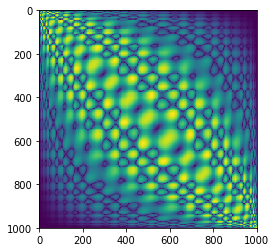

In [222]:
plt.imshow(abs(kiss_40_model_cov-exact_GP_cov), interpolation='nearest', norm=colors.PowerNorm(gamma=1. / 2.),)
plt.show()

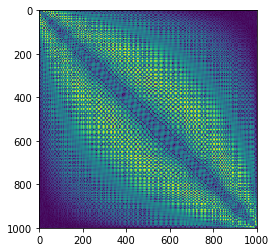

In [223]:
plt.imshow(abs(kiss_150_model_cov-exact_GP_cov), interpolation='nearest', norm=colors.PowerNorm(gamma=1. / 2.),)
plt.show()